In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sympy as sp

import ThermoAcousticClass

In [2]:
os.getcwd()

'/mnt/c/Users/admin/Documents/workspace/fyp'

# Acoustic Modes

The general matrix method will be solved for an open-open duct with no mean flow, assuming harmoic vibrations

$$ \mathbf{M} \begin{bmatrix} A \\ B \end{bmatrix} = \mathbf{0} $$

where 

$$ \mathbf{M} = \begin{bmatrix} 1 & -R_{u} \\ R_{d}exp\left(-\frac{i\omega L}{\bar{c}} \right) & -exp\left(\frac{i\omega L}{\bar{c}} \right) \end{bmatrix} $$


The aim is to solve for $\omega$ such that $det(\mathbf{M}) = 0$

In [3]:
# Defining variables
c = 345 # m/s, speed of sound
L = 0.75 # m, length of tube
Ru = -1 # upstream reflection coefficient
Rd = -1 # downstream refection coefficient
j = complex(0, 1)
e = np.e

# Function which returns the determinent of the matrix M
def matrix_det(w, Ru, Rd):
    det = -sp.exp(j*w*L/c) + Rd*Ru*sp.exp(-j*w*L/c)
    return det

In [4]:
# using solver to solve for w which gives det(M) = 0
w = sp.Symbol('w')
wl = sp.solveset(matrix_det(w, Ru, Rd), w, domain=sp.S.Complexes)
sp.pprint(wl)

{460.0⋅n⋅π │ n ∊ ℤ}


In [5]:
# Converting infinite set into generator object, taking first 100 elements and adding to a list
# Contains positive and negative numbers. Will only consider positive values of n (n=0 gives w=0)
wl_iterable = iter(wl)
wl_all = [complex(next(wl_iterable)) for i in range(100)] # Taking the first 100 solutions, can take more if wanted. Goes in order 0, 1, -1, 2, -2, ...

# taking positive values, want n = 1, 2, 3..., aka the odd indices in the wl_all list
w_n = [wl_all[i] for i in range(len(wl_all)) if (i%2 == 1)]
w_n = np.asarray(w_n)

In [6]:
# Function for calculating pressure fluctuations, saying A0 = 1

def p_fluc(k, Boundary=0):
    '''
    Returns pressure fluctuations within duct.
    Two different return values possible, depending on which 
    boundary condition is chosen. 
    Boundary=0 for boundary condition at x=0 (default), Boundary=1
    for boundary at x=L. In the simplest case, both should return
    the same values. 
    '''
    # Defining x axis
    x = np.linspace(0, L, 1000)[..., np.newaxis]
    
    if Boundary == 0:
        return e**((-j*k*x)) + 1/Ru*e**(j*k*x) # using BC and x = 0
    elif Boundary == 1:
        return e**((-j*k*x)) + Rd*e**(-2*j*k*L)*e**(j*k*x) # using BC at x = L

In [7]:
p = p_fluc(w_n/c, 0)
p.shape

(1000, 50)

In [8]:
def plot_modes(p_prime, labels=None):
    x = np.linspace(0, L, 1000)[..., np.newaxis]
    plt.plot(x, np.abs(p_prime), label = labels)
    plt.ylabel('|p\'|')
    plt.xlabel('Length')
    plt.legend(loc='upper left')
    plt.show()

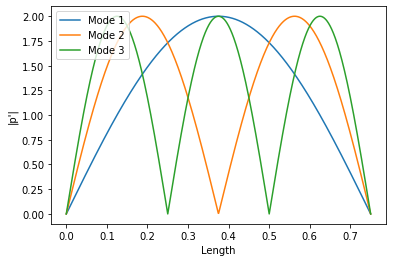

In [9]:
plot_modes(p[:,:3], ['Mode 1', 'Mode 2', 'Mode 3'])

# Viscous Effects

The assumptions for this viscous model are: 
- Low frequency, i.e. $kR_t<<1$
- High shear numbers, i.e. $Sh = R_t\left(\frac{\omega}{\nu}\right)^{\frac{1}{2}}>>1$

Where $R_t$ is the radius of the pipe

In [10]:
Rt = 0.005 #m
gamma = 1.4
T = 950 # K
density = 0.29 # kgm-3, https://www.engineeringtoolbox.com/air-density-specific-weight-d_600.html
Cp = 1175 # J/(Kg K), specific heat of air
Pr = 0.72 # Prandtl number, https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm

def Dynamic_viscosity(T):
    '''
    Dynamic viscosity of air as a function of temperature.
    Estimated by Sutherland's Law. 
    '''
    if (100 <= T <= 1000):
        return 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
    elif(1000 <= T <= 3000):
        return 2.653e-8*T+1.573e-5

kin_visc = Dynamic_viscosity(950)/density
    
def Shear(w, nu):
    return Rt*(w/nu)**(1/2)

def k_correction(w):
    Sh = Shear(w, kin_visc)
    return w/c*(1+(1-j)/np.sqrt(2)/Sh*(1+(gamma-1)/(Pr**(1/2)))-j/(Sh**2)*(1+(gamma-1)/(Pr**(1/5))-gamma/2*(gamma-1)/Pr))
    #return w/c*(1+(1-j)/np.sqrt(2)/Sh*(1+(gamma-1)/(Pr**(1/2))))

In [11]:
kc = k_correction(w_n)
p_vd = p_fluc(kc, 0) # Return values different depending on boundary condition? 

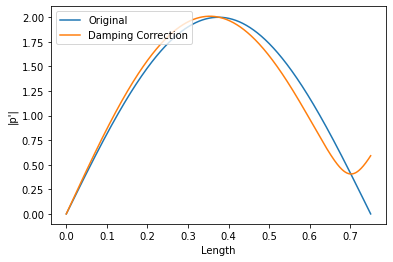

In [12]:
plot_modes(np.concatenate([p[:,0][...,np.newaxis], p_vd[:,0][...,np.newaxis]], axis=1), ['Original', 'Damping Correction']) 

# Non-reflective Boundary Conditions

In [13]:
# Assert that
w = 1840*np.pi
L = 0.75

In [14]:
kc = k_correction(w)
a = np.real(kc)
b = np.imag(kc) # the negative part of the corrected wavenumber gives the damping!

In [15]:
x = np.linspace(0, L, 1000)[..., np.newaxis]
p_orig = np.cos(-w/c*x)
p_damping = np.exp(b*x)*np.cos(-a*x)
p_data = np.concatenate([p_orig, p_damping], axis=1)

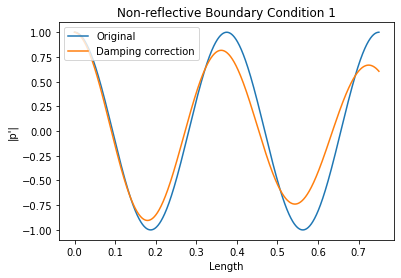

In [16]:
plt.plot(x, p_data, label = ['Original', 'Damping correction'])
plt.ylabel('|p\'|')
plt.xlabel('Length')
plt.legend(loc='upper left')
plt.title('Non-reflective Boundary Condition 1')
plt.show()

In [17]:
x = np.linspace(0, -L, 1000)[...,np.newaxis]
p_orig = np.cos(w/c*x)
p_damping = np.exp(-b*x)*np.cos(a*x)
p_data = np.concatenate([p_orig, p_damping], axis=1)

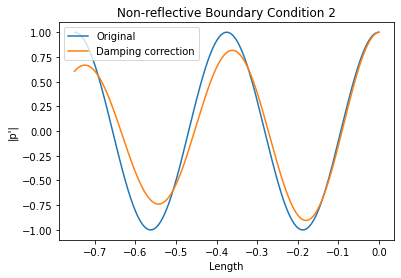

In [18]:
plt.plot(x, p_data, label = ['Original', 'Damping correction'])
plt.ylabel('|p\'|')
plt.xlabel('Length')
plt.legend(loc='upper left')
plt.title('Non-reflective Boundary Condition 2')
plt.show()

# Temperature Gradient Modelling

User specifies:
- Temperature gradient (linear or sinusoidal) or arbitrary heat release rate
- Arbitrary inlet conditions

Set of differential equations:

$$\frac{d\bar{u}}{dx} = -\bar{u}\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{d\bar{p}}{dx} = \bar{\rho}\bar{u}^2\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\bar{\dot{q}}=\bar{\rho}\bar{u}\left(c_p\frac{d\bar{T}}{dx}+\bar{u}\frac{d\bar{u}}{dx}\right)$$

$$\frac{1}{\bar{T}}\frac{d\bar{T}}{dx}=\frac{1}{\bar{p}}\frac{d\bar{p}}{dx}-\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}=-(1-\gamma M^2)\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{1}{\bar{c}}\frac{d\bar{c}}{dx}=\frac{1}{2\bar{T}}\frac{d\bar{T}}{dx}=-\frac{1-\gamma M^2}{2}\frac{1}{\bar{\rho}}\frac{d\bar{\rho}}{dx}$$

$$\frac{dM}{d\bar{x}}=\frac{1}{\bar{c}}\frac{d\bar{u}}{dx}-\frac{M}{\bar{c}}\frac{d\bar{c}}{dx}=-\frac{M(1+\gamma M^2)}{2}\alpha$$


In [177]:
# Initial conditions
l = 0.2 # m
x1 = 0 # m
p1 = 1e5 # Pa
T1 = 1400 # K
T2 = 500 # K
M1 = 0.2
Z1 = -1
gamma = 1.4
Rg = 287 #J/K/kg

c1 = np.sqrt(gamma*Rg*T1) # m/s
u1 = M1*c1 # m/s
rho1 = p1/(Rg*T1) # kg/m3

# Defining constants
A = rho1*u1
B = p1 + rho1*u1**2

In [178]:
x = np.linspace(0, l, 101)
dx = x[1]-x[0]

In [179]:
# Temperature distribution
T = T1 + (T2-T1)/l*(x-x1)
# T = (T1-T2)/2*np.sin(5*np.pi/4*(x-x1)/l + np.pi/4)+(T1+T2)/2

In [180]:
T

array([1400., 1391., 1382., 1373., 1364., 1355., 1346., 1337., 1328.,
       1319., 1310., 1301., 1292., 1283., 1274., 1265., 1256., 1247.,
       1238., 1229., 1220., 1211., 1202., 1193., 1184., 1175., 1166.,
       1157., 1148., 1139., 1130., 1121., 1112., 1103., 1094., 1085.,
       1076., 1067., 1058., 1049., 1040., 1031., 1022., 1013., 1004.,
        995.,  986.,  977.,  968.,  959.,  950.,  941.,  932.,  923.,
        914.,  905.,  896.,  887.,  878.,  869.,  860.,  851.,  842.,
        833.,  824.,  815.,  806.,  797.,  788.,  779.,  770.,  761.,
        752.,  743.,  734.,  725.,  716.,  707.,  698.,  689.,  680.,
        671.,  662.,  653.,  644.,  635.,  626.,  617.,  608.,  599.,
        590.,  581.,  572.,  563.,  554.,  545.,  536.,  527.,  518.,
        509.,  500.])

In [181]:
# Speed of sound c

c_bar = np.sqrt(gamma*Rg*T)
u_bar = (B/A - np.sqrt((B/A)**2-4*Rg*T))/2
rho_bar = A/u_bar
p_bar = rho_bar*Rg*T
M = u_bar/c_bar

In [182]:
def grad(q):
    dqdx = np.zeros(q.shape)
    dqdx[1:-1] = (q[2:]-q[:-2])/(2*dx)
    dqdx[0] = (q[1]-q[0])/dx
    dqdx[-1] = (q[-1]-q[-2])/dx
    return dqdx

In [183]:
alph = 1/rho_bar*grad(rho_bar) # Using numerical gradient
alpha = -1/rho_bar*1/(1-gamma*M**2)*rho_bar/T*(-800) # Using analytical gradient

In [184]:
alpha

array([0.60532688, 0.60898385, 0.61268909, 0.61644354, 0.62024816,
       0.62410397, 0.62801197, 0.63197323, 0.63598882, 0.64005986,
       0.64418748, 0.64837285, 0.65261718, 0.65692171, 0.66128771,
       0.66571649, 0.6702094 , 0.67476782, 0.67939317, 0.68408694,
       0.68885062, 0.69368578, 0.69859402, 0.70357698, 0.70863638,
       0.71377395, 0.71899152, 0.72429095, 0.72967415, 0.73514312,
       0.74069989, 0.74634658, 0.75208537, 0.75791852, 0.76384834,
       0.76987725, 0.77600772, 0.78224232, 0.78858371, 0.79503464,
       0.80159793, 0.80827654, 0.81507351, 0.82199199, 0.82903524,
       0.83620665, 0.84350973, 0.8509481 , 0.85852554, 0.86624597,
       0.87411344, 0.88213217, 0.89030654, 0.8986411 , 0.90714058,
       0.9158099 , 0.92465417, 0.93367871, 0.94288906, 0.952291  ,
       0.96189053, 0.97169393, 0.98170772, 0.99193873, 1.00239406,
       1.01308115, 1.02400776, 1.03518199, 1.04661233, 1.05830766,
       1.07027726, 1.08253085, 1.09507864, 1.10793131, 1.12110

In [185]:
from scipy.integrate import quad

In [186]:
def cbarT(T):
    return np.sqrt(gamma*Rg*T)

def ubarT(T):
    return (B/A - np.sqrt((B/A)**2-4*Rg*T))/2

def T_x(x):
    return T1+(T2-T1)*(x-x1)/l

# def t_x(x):
#     pass

In [187]:
def integrand_plus(x):
    return 1/(cbarT(T_x(x)) + ubarT(T_x(x)))

def integrand_minus(x):
    return 1/(cbarT(T_x(x)) - ubarT(T_x(x)))

In [188]:
def integral_plus(x):
    return quad(integrand_plus, x1, x)[0]

def integral_minus(x):
    return quad(integrand_minus, x1, x)[0]

In [189]:
integrals_plus = np.array([integral_plus(value) for value in x])
integrals_minus = np.array([integral_minus(value) for value in x])

In [233]:
# For velocity fluctuations:
w = 2*np.pi*c_bar[0]/l
k0 = lambda w: w/c_bar

P1_plus = lambda w: (rho_bar/rho1)**(1/4)*(1+M1)/(1+M)*(np.exp(gamma*M1-gamma/4*M1**2-(gamma**2-1)/3*M1**3))/(np.exp(gamma*M-gamma/4*M**2-(gamma**2-1)/3*M**3))*np.exp(-j*w*integrals_plus)
P1_minus= lambda w: (rho_bar/rho1)**(1/4)*(1-M1)/(1-M)*(np.exp(gamma*M+gamma/4*M**2-(gamma**2-1)/3*M**3))/(np.exp(gamma*M1+gamma/4*M1**2-(gamma**2-1)/3*M1**3))*np.exp(j*w*integrals_minus)

K1 = lambda w: (j*k0(w)-(1+2*(1+gamma)*M+(3*gamma-7)*M**2)*alph/4)/(j*k0(w)-alph*M)
K2 = lambda w: (j*k0(w)+(1-2*(1+gamma)*M+(3*gamma-7)*M**2)*alph/4)/(j*k0(w)-alph*M)

#C1_plus = (P1_minus[0]*K2[0]-P1_minus[0])/(P1_plus[0]+P1_plus[0]*K1[0])
#C1_minus = 1

In [307]:
Z1 = -1
u0 = u_bar[0]
p0 = rho_bar[0] * c_bar[0] * Z1 * u0
init = np.array([[p0], [u0]])

In [308]:
init

array([[-28000.        ],
       [   150.00266664]])

In [316]:
tmp = np.array([[1, 1], [K1(w)[0]/rho_bar[0]/c_bar[0], -K2(w)[0]/rho_bar[0]/c_bar[0]]])

In [319]:
np.linalg.inv(tmp)

array([[  0.49968323-0.01209983j,  93.32102018-0.40695388j],
       [  0.50031677+0.01209983j, -93.32102018+0.40695388j]])

In [320]:
C = np.matmul(np.linalg.inv(tmp), init)

In [321]:
C

array([[ 7.27144144e+00+277.75096057j],
       [-2.80072714e+04-277.75096057j]])

In [322]:
C1_plus = C[0][0]
C1_minus = C[1][0]

In [323]:
C1_minus

(-28007.271441440385-277.7509605712887j)

In [324]:
C1_minus

(-28007.271441440385-277.7509605712887j)

In [325]:
def matrix_det(w):
    det = P1_plus(w)[-1] * (P1_minus(w)[0] - K1(w)[0]*P1_minus(w)[0]) - P1_minus(w)[-1] * (P1_plus(w)[0] + K1(w)[0]*P1_plus(w)[0])
    return det

In [326]:
def matrix_det2(w):
    det = P1_plus(w)[-1] * P1_minus(w)[0] - P1_minus(w)[-1] * (P1_plus(w)[0] + K1(w)[0]*P1_plus(w)[0])
    return det

In [327]:
tmp = lambda w: K1(w)[0]*P1_plus(w)[0]+1

In [328]:
p_hat = C1_plus*P1_plus(w) + C1_minus*P1_minus(w)
u_hat = K1(w)*C1_plus*P1_plus(w)/(rho_bar*c_bar) - K2(w)*C1_minus*P1_minus(w)/(rho_bar*c_bar)

In [329]:
Fp = p_hat/(rho_bar[0]*c_bar[0]*u_hat[0])
Fu = u_hat/u_hat[0]

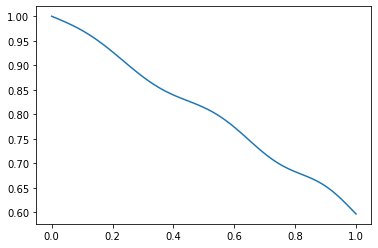

In [330]:
plt.plot(x/l, abs(Fu))
plt.show()

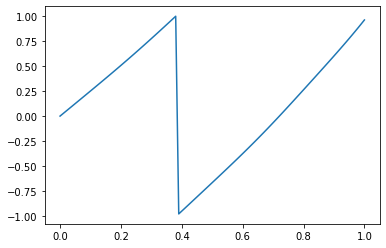

In [331]:
plt.plot(x/l, np.angle(Fu)/np.pi)